# Lab 1 - Creating a Slice with a P4 Switch

This lab will walk you through creating an experiment that contains a a P4 programmable switch. The P4 switch that we will use is a software switch known as the behavioral model (BMv2).  Specifically, the experiment deploys a slice with three nodes: two end-hosts and a P4 switch. The topology is shown in the figure below

<img src="./labs_files/lab1/figs/fabric_topology.png" width="550px"><br>


# Step 1:  Configure the Environment

Before running this notebook, you will need to configure your environment using the [Configure Environment](../../../configure.ipynb) notebook. Please stop here, open and run that notebook, then return to this notebook.

If you are using the FABRIC JupyterHub many of the environment variables will be automatically configured for you.  You will still need to set your bastion username, upload your bastion private key, and set the path to where you put your bastion private key. Your bastion username and private key should already be in your possession.  

If you are using the FABRIC API outside of the JupyterHub you will need to configure all of the environment variables. Defaults below will be correct in many situations but you will need to confirm your configuration.  If you have questions about this configuration, please contact the FABRIC admins using the [FABRIC User Forum](https://learn.fabric-testbed.net/forums/) 

More information about accessing your experiments through the FABRIC bastion hosts can be found [here](https://learn.fabric-testbed.net/knowledge-base/logging-into-fabric-vms/).
 

# Step 2: Import the FABlib Library

In [18]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager()

# Step 3: Create the Experiment Slice

The following creates three node with basic compute and networking capabilities. You build a slice by creating a new slice and adding resources to the slice. After you build the slice, you must submit a request for the slice to be instantiated.   

### Step 3.1: Create a slice
The code below creates a new slice with the name "lab1"

In [19]:
slice = fablib.new_slice(name="lab1")

### Step 3.2: Define the sites
The code below requests three sites from FABRIC: INDI, STAR, and NCSA

<img src="./labs_files/lab1/figs/fabric_sites.png" width="550px"><br>

In [20]:
site1='MICH'
site2='STAR'
site3='NCSA'

print (f'The selected sites are {site1}, {site2}, {site3}') 

The selected sites are MICH, STAR, NCSA


### Step 3.3: Creating the nodes
The code below creates two nodes: server1 and server2. The servers (server1 and server2) use the following:
<ul>
    <li> 4 CPU cores</li>
    <li> 8GB RAM </li>
    <li> 20GB disc size </li>
    <li> Image: Ubuntu 20.04
</ul>

server1 will be created in site1 and server3 will be created in site3

<img src="./labs_files/lab1/figs/creating_nodes.PNG" width="550px"><br>

In [21]:
server1 = slice.add_node(name="server1", 
                      site=site1, 
                      cores=4, 
                      ram=8, 
                      disk=20, 
                      image='default_ubuntu_20')

server2 = slice.add_node(name="server2", 
                      site=site3, 
                      cores=4, 
                      ram=8, 
                      disk=20, 
                      image='default_ubuntu_20')

### Step 3.4: Adding the interfaces to the servers
The code below adds a Network Interface Card (NIC) to each server.

<img src="./labs_files/lab1/figs/adding_nics.PNG" width="550px"><br>

In [22]:
server1_iface = server1.add_component(model='NIC_Basic').get_interfaces()[0]
server2_iface = server2.add_component(model='NIC_Basic').get_interfaces()[0]

### Step 3.5: Creating a node for the P4 switch
The code below creates a node that will run the P4 switch. The node use the following
<ul>
    <li> 16 CPU cores</li>
    <li> 8GB RAM </li>
    <li> 40GB disc size </li>
    <li> Image: Ubuntu 20.04
</ul>

The node will be created in site2

<img src="./labs_files/lab1/figs/adding_switch.PNG" width="550px"><br>

In [23]:
# Add a node
switch = slice.add_node(name="switch", 
                      site=site2, 
                      cores=32, 
                      ram=16, 
                      disk=40, 
                      image='default_ubuntu_20')

### Step 3.6: Adding two interfaces to the switch
The code below adds two Network Interface Cards (NICs) to the switch.

<img src="./labs_files/lab1/figs/adding_switch_ports.PNG" width="550px"><br>

In [24]:
switch_iface1 = switch.add_component(model='NIC_Basic', name='net1_nic').get_interfaces()[0]
switch_iface2 = switch.add_component(model='NIC_Basic', name='net2_nic').get_interfaces()[0]

### Step 3.7: Connecting site1 and site2
Create a site-to-site network between site1 and site2 connecting server1 and the P4 switch

<img src="./labs_files/lab1/figs/connecting_nodes_server1_switch.PNG" width="550px"><br>

In [25]:
net1 = slice.add_l2network(name='net1', interfaces=[server1_iface, switch_iface1])

### Step 3.8: Connecting site2 and site3
Create a site-to-site network between site2 and site3 connecting the P4 switch and server2

<img src="./labs_files/lab1/figs/connecting_nodes_server2_switch.PNG" width="550px"><br>

In [26]:
net2 = slice.add_l2network(name='net2', interfaces=[switch_iface2, server2_iface])

### Step 3.9: Submitting the slice
The code below submits the slice. 
By default, the submit function will block until the node is ready and will display the progress of your slice being built.

In [27]:
#Submit Slice Request
slice.submit();


Retry: 20, Time: 452 sec


ID,4b838f4b-b0db-478e-a17e-7fc08ab95a50
Name,lab1
Lease Expiration (UTC),2024-07-27 13:43:19 +0000
Lease Start (UTC),2024-07-26 13:43:19 +0000
Project ID,16eafd43-3e6c-4546-854c-935eea16552a
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
db9e5fcc-80ed-45bd-9666-5be24e0543c4,server1,4,8,100,default_ubuntu_20,qcow2,mich-w1.fabric-testbed.net,MICH,ubuntu,2607:f018:110:11:f816:3eff:feef:a276,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2607:f018:110:11:f816:3eff:feef:a276,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
c77e04c1-f9d9-4803-8b94-f9838d2c87c7,server2,4,8,100,default_ubuntu_20,qcow2,ncsa-w2.fabric-testbed.net,NCSA,ubuntu,2620:0:c80:1001:f816:3eff:fe73:4713,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:c80:1001:f816:3eff:fe73:4713,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
f994d853-e7be-44a1-b1fc-f119a98705fb,switch,32,16,100,default_ubuntu_20,qcow2,star-w5.fabric-testbed.net,STAR,ubuntu,2001:400:a100:3030:f816:3eff:fe6d:aa3a,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3030:f816:3eff:fe6d:aa3a,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
1aa8f3ee-d193-4063-92b5-df62709fcdfe,net1,L2,L2STS,None,None,None,Active,
781086d1-ac17-4a1e-8df1-b38cb6dfe723,net2,L2,L2STS,None,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node,Switch Port
server1-None-p1,p1,server1,net1,100,config,,0A:12:96:05:9F:94,enp7s0,enp7s0,fe80::812:96ff:fe05:9f94,6,HundredGigE0/0/0/5
server2-None-p1,p1,server2,net2,100,config,,0A:3C:E2:22:45:E2,enp7s0,enp7s0,fe80::83c:e2ff:fe22:45e2,4,HundredGigE0/0/0/9
switch-net1_nic-p1,p1,switch,net1,100,config,,06:C2:F3:99:A2:F2,enp8s0,enp8s0,fe80::4c2:f3ff:fe99:a2f2,4,HundredGigE0/0/0/1
switch-net2_nic-p1,p1,switch,net2,100,config,,02:A3:D4:83:27:12,enp7s0,enp7s0,fe80::a3:d4ff:fe83:2712,4,HundredGigE0/0/0/1



Time to print interfaces 465 seconds


# Step 4: Installing the required packages
In this step, we will install the required packages to run the lab. Specifically, we will install the BMv2 software switch and its control plane, the P4 compiler (p4c), and net-tools.

## Step 4.1 Installing BMv2
The BMv2 software switch will be installed on the switch node. We will upload the script [scripts/install_bmv2.sh](./scripts/install_bmv2.sh) to the switch and execute it

In [28]:
switch = slice.get_node(name="switch")     
switch.upload_file('scripts/install_bmv2.sh', 'install_bmv2.sh')
stdout, stderr = switch.execute(f'chmod +x install_bmv2.sh &&  ./install_bmv2.sh',quiet=True)

## Step 4.2 Installing net-tools
The net-tools package will be installed on the switch, server1 and server2 nodes. This package will allow us to use the *ifconfig* and the *arp* commands 

In [29]:
server1 = slice.get_node(name="server1")
server2 = slice.get_node(name="server2")
stdout, stderr = server1.execute(f'sudo apt-get install -y net-tools', quiet=True)
stdout, stderr = server2.execute(f'sudo apt-get install -y net-tools', quiet=True)
stdout, stderr = switch.execute(f'sudo apt-get install -y net-tools', quiet=True)

# Step 5: Assigning IP and MAC addresses
In this step, we will assign IPv4 addresses to the interfaces of the servers and the switch. We will also hardcode the MAC addresses. 

## Step 5.1: Get interfaces names
In this step we will get the interface names so that we can assign IP addresses to them. Map the printed interface names to those seen in this figure:

<img src="./labs_files/lab1/figs/interfaces.PNG" width="550px"><br>

In [30]:
node1_iface = server1.get_interface(network_name='net1') 
server1_iface_name = node1_iface.get_device_name()
print(f'server1_iface: {server1_iface_name}')

node2_iface = server2.get_interface(network_name='net2') 
server2_iface_name = node2_iface.get_device_name()
print(f'server2_iface: {server2_iface_name}')

switch_iface1 = switch.get_interface(network_name='net1') 
switch_iface1_name = switch_iface1.get_device_name()
print(f'switch_iface1: {switch_iface1_name}')

switch_iface2 = switch.get_interface(network_name='net2') 
switch_iface2_name = switch_iface2.get_device_name()
print(f'switch_iface2: {switch_iface2_name}')

server1_iface: enp7s0
server2_iface: enp7s0
switch_iface1: enp8s0
switch_iface2: enp7s0


## Step 5.2: Turning all interfaces up
In this step, we will use the ip link command to turn the interfaces up

<img src="./labs_files/lab1/figs/interfaces_up.PNG" width="550px"><br>

In [31]:
stdout, stderr = server1.execute(f'sudo ip link set dev {server1_iface_name} up', quiet=True)
stdout, stderr = server2.execute(f'sudo ip link set dev {server2_iface_name} up', quiet=True)
stdout, stderr = switch.execute(f'sudo ip link set dev {switch_iface1_name} up', quiet=True)
stdout, stderr = switch.execute(f'sudo ip link set dev {switch_iface2_name} up', quiet=True)

## Step 5.3: Hardcode MAC addresses
For simplicity, we will use the following MAC addresses for the interfaces:
<ul>
    <li> server1_iface_MAC = '00:00:00:00:00:01' (shown as 00:01 in the figure below) </li>
    <li>switch_iface1_MAC = '00:00:00:00:00:02' (shown as 00:02 in the figure below)</li>
    <li>switch_iface2_MAC = '00:00:00:00:00:03' (shown as 00:03 in the figure below)</li>
    <li>server2_iface_MAC = '00:00:00:00:00:04' (shown as 00:04 in the figure below)</li>
</ul>

<img src="./labs_files/lab1/figs/mac_addresses.PNG" width="550px"><br>

In [32]:
server1_iface_MAC = '00:00:00:00:00:01'
switch_iface1_MAC = '00:00:00:00:00:02'
switch_iface2_MAC = '00:00:00:00:00:03'
server2_iface_MAC = '00:00:00:00:00:04'

## Step 5.4 Configuring the IP and MAC addresses on server1_iface and switch_iface1

We will use the network 192.168.1.0/24 between Site1 and Site2. We will assign the IP address 192.168.1.10 to server1's interface and 192.168.1.1 to its neighboring interface on the switch.

<img src="./labs_files/lab1/figs/IPs_1.PNG" width="550px"><br>

In [33]:
server1_switch_subnet = "192.168.1.0/24"
server1_ip = '192.168.1.10/24'
switch_ip1 = '192.168.1.1/24'

stdout, stderr = server1.execute(f'sudo ifconfig {server1_iface_name} {server1_ip}')
stdout, stderr = switch.execute(f'sudo ifconfig {switch_iface1_name} {switch_ip1}')

stdout, stderr = server1.execute(f'sudo ifconfig {server1_iface_name} hw ether {server1_iface_MAC}')
stdout, stderr = switch.execute(f'sudo ifconfig {switch_iface1_name} hw ether {switch_iface1_MAC}')

## Step 5.5: Configuring the IP and MAC addresses on switch_iface2 and server2_iface

We will use the network 192.168.2.0/24 between Site2 and Site3. We will assign the IP address 192.168.2.10 to server2's interface and 192.168.2.1 to its neighboring interface on the switch.

<img src="./labs_files/lab1/figs/IPs_2.PNG" width="550px"><br>

In [34]:
server2_switch_subnet = "192.168.2.0/24"
server2_ip = '192.168.2.10/24'
switch_ip2 = '192.168.2.1/24'

stdout, stderr = server2.execute(f'sudo ifconfig {server2_iface_name} {server2_ip}')
stdout, stderr = switch.execute(f'sudo ifconfig {switch_iface2_name} {switch_ip2}')

stdout, stderr = server2.execute(f'sudo ifconfig {server2_iface_name} hw ether {server2_iface_MAC}')
stdout, stderr = switch.execute(f'sudo ifconfig {switch_iface2_name} hw ether {switch_iface2_MAC}')

# Step 6: Configure forwarding and routing

## Step 6.1: Enable forwarding on the switch

The command "sudo sysctl -w net.ipv4.ip_forward=1" is used to enable IP forwarding on a Linux system.

IP forwarding is a feature that allows a system to act as a router by forwarding network packets from one network interface to another. By default, IP forwarding is usually disabled on Linux systems for security reasons. 

The command will be executed on the switch device.

In [35]:
stdout, stderr = switch.execute('sudo sysctl -w net.ipv4.ip_forward=1' , quiet=True)

## Step 6.2: Delete routing entries for the routes to force traffic to go through the BMv2 switch

In this step, we are deleting the routes on the switch's routing table in Linux. By deleting the routes, the packets will go through the BMv2 switch instead of being forwarded by the kernel.

In [36]:
stdout, stderr = switch.execute(f'sudo ip route del {server1_switch_subnet}', quiet=True)
stdout, stderr = switch.execute(f'sudo ip route del {server2_switch_subnet}', quiet=True)

## Step 6.3: Configure routing

In this step, we will configure static routes on server1 and server2. 
<ul>
    <li> For server1, we will add a route to reach the network 192.168.2.0/24 via 192.168.1.1 </li>
    <li> For server2, we will add a route to reach the network 192.168.1.0/24 via 192.168.2.1 </li>
</ul>

<img src="./labs_files/lab1/figs/routing.PNG" width="550px"><br>

In [37]:
gw1 = switch_ip1.split('/')[0] # gw1 -> 192.168.1.1 
gw2 = switch_ip2.split('/')[0] # gw2 -> 192.168.2.1
stdout, stderr = server1.execute(f'sudo ip route add {server2_switch_subnet} via {gw1}')
stdout, stderr = server2.execute(f'sudo ip route add {server1_switch_subnet} via {gw2}')

## Step 6.4: Configure ARP

In this step, we will configure static ARP entries on server1 and server2. The reason we are doing this is because the switch does not process ARP packets unless programmed to. To make sure that ARP packets are not sent towards the switch, we will hardcode the MACs on the servers.

For each server, we will add an ARP entry to its switch's neighboring interface.

In [38]:
stdout, stderr = server1.execute(f'sudo arp -s {gw1} {switch_iface1_MAC}')
stdout, stderr = server2.execute(f'sudo arp -s {gw2} {switch_iface2_MAC}')

# Step 7: Compiling and starting a simple P4 routing program

In this step, we will compile the P4 program and start the switch using the *p4c* compiler. To view and edit the P4 program, [Click Here](labs_files/lab1/main.p4)

The P4 program [main.p4](labs_files/lab1/main.p4) is located under lab_files/lab1/.

We will stop any previous instance of the switch (if any is existing) by killing its process.

Then, we will start the switch and allocate the interfaces to logical ports. 

<img src="./labs_files/lab1/figs/starting_switch.PNG" width="550px"><br>

In [39]:
switch.upload_file('scripts/main.p4', 'main.p4')
stdout, stderr = switch.execute(f'p4c main.p4')
stdout, stderr = switch.execute(f'sudo pkill simple_switch')
stdout, stderr = switch.execute(f'sudo simple_switch -i 0@{switch_iface1_name} -i 1@{switch_iface2_name} main.json &')

Calling target program-options parser
Adding interface enp8s0 as port 0
Adding interface enp7s0 as port 1


## Step 7.1: Populating table from the control plane

In this step we will populate the forwarding table by executing a script. We will learn how to populate the tables manually in another lab.

In [40]:
switch.upload_file('scripts/rules.sh', 'rules.sh')
stdout, stderr = switch.execute('chmod +x rules.sh && ./rules.sh')

Obtaining JSON from switch...
Done
Control utility for runtime P4 table manipulation
RuntimeCmd: Adding entry to lpm match table MyIngress.ipv4_lpm
match key:           LPM-c0:a8:01:00/24
action:              MyIngress.forward
runtime data:        00:00:00:00:00:01	00:00
Entry has been added with handle 0
RuntimeCmd: 
Obtaining JSON from switch...
Done
Control utility for runtime P4 table manipulation
RuntimeCmd: Adding entry to lpm match table MyIngress.ipv4_lpm
match key:           LPM-c0:a8:02:00/24
action:              MyIngress.forward
runtime data:        00:00:00:00:00:04	00:01
Entry has been added with handle 1
RuntimeCmd: 


## Step 7.2: Running a ping test

In [41]:
server2_dest_ip = server2_ip.split('/')[0]
stdout, stderr = server1.execute(f'ping {server2_dest_ip} -c 3')

PING 192.168.2.10 (192.168.2.10) 56(84) bytes of data.
64 bytes from 192.168.2.10: icmp_seq=1 ttl=63 time=10.7 ms
64 bytes from 192.168.2.10: icmp_seq=2 ttl=63 time=9.98 ms
64 bytes from 192.168.2.10: icmp_seq=3 ttl=63 time=10.0 ms

--- 192.168.2.10 ping statistics ---
3 packets transmitted, 3 received, 0% packet loss, time 2003ms
rtt min/avg/max/mdev = 9.979/10.233/10.671/0.311 ms


In [42]:
server1.get_ssh_command()

'ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2607:f018:110:11:f816:3eff:feef:a276'

In [43]:
server2.get_ssh_command()

'ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:c80:1001:f816:3eff:fe73:4713'

# Step 8: Running High Performance BMv2

In this step, we will use the BMv2 switch with logging disabled. By disabling logging, the switch will be able to process traffic at higher rates. 

The binary of the BMv2 switch with logging disabled (*simple_switch_hp*) is located under *scripts/* directory. 

## Step 8.1: Uploading the binary to the switch 
The command below uploads the binary to the switch device. It also stops the previous instance of the switch.

In [44]:
switch.upload_file('scripts/simple_switch_hp.gz', '/home/ubuntu/simple_switch_hp.gz')
switch.execute('gzip -d simple_switch_hp.gz')
switch.execute('chmod +x /home/ubuntu/simple_switch_hp')
stdout, stderr = switch.execute(f'sudo pkill switch')

## Step 8.2: Disable TCP offloading

The command below disables TCP offloading. This step is crucial to get high rates.

In [45]:
switch.upload_file('scripts/disable_offload.sh', 'disable_offload.sh')
stdout, stderr = switch.execute(f'sudo chmod +x ./disable_offload.sh && sudo ./disable_offload.sh {switch_iface1_name}', quiet=True)
stdout, stderr = switch.execute(f'sudo chmod +x ./disable_offload.sh && sudo ./disable_offload.sh {switch_iface2_name}', quiet=True)

## Step 8.3: Running the switch

This will start the high performance switch and allocate the interfaces, then will push the rules from the control plane.

In [46]:
stdout, stderr = switch.execute(f'sudo /home/ubuntu/simple_switch_hp -i 0@{switch_iface1_name} -i 1@{switch_iface2_name} main.json &')
stdout, stderr = switch.execute('chmod +x rules.sh && ./rules.sh')

Calling target program-options parser
Adding interface enp8s0 as port 0
Adding interface enp7s0 as port 1
Obtaining JSON from switch...
Done
Control utility for runtime P4 table manipulation
RuntimeCmd: Adding entry to lpm match table MyIngress.ipv4_lpm
match key:           LPM-c0:a8:01:00/24
action:              MyIngress.forward
runtime data:        00:00:00:00:00:01	00:00
Entry has been added with handle 0
RuntimeCmd: 
Obtaining JSON from switch...
Done
Control utility for runtime P4 table manipulation
RuntimeCmd: Adding entry to lpm match table MyIngress.ipv4_lpm
match key:           LPM-c0:a8:02:00/24
action:              MyIngress.forward
runtime data:        00:00:00:00:00:04	00:01
Entry has been added with handle 1
RuntimeCmd: 


## Step 8.4 Installing iPerf3
iPerf3 will be installed on server1 and server2 nodes. We will use the APT package manager to install it. 

In [47]:
stdout, stderr = server1.execute(f'sudo apt-get update && sudo apt-get install -y iperf3', quiet=True)
stdout, stderr = server2.execute(f'sudo apt-get update && sudo apt-get install -y iperf3', quiet=True)

## Step 8.5: Starting iPerf3 on server2 

iPerf3 will be started in server mode on server2. 

In [34]:
server2.execute_thread('iperf3 -s')

<Future at 0x7895703a1a10 state=pending>

## Step 8.6: Starting iPerf3 client on server1 

iPerf3 will be started in client mode on server1. It will connect to the iPerf3 server on server2.

In [35]:
stdout, stderr = server1.execute('iperf3 -c 192.168.2.10 -P 5')

Connecting to host 192.168.2.10, port 5201
[  5] local 192.168.1.10 port 57462 connected to 192.168.2.10 port 5201
[  7] local 192.168.1.10 port 57468 connected to 192.168.2.10 port 5201
[  9] local 192.168.1.10 port 57470 connected to 192.168.2.10 port 5201
[ 11] local 192.168.1.10 port 57472 connected to 192.168.2.10 port 5201
[ 13] local 192.168.1.10 port 57478 connected to 192.168.2.10 port 5201
[ ID] Interval           Transfer     Bitrate         Retr  Cwnd
[  5]   0.00-1.00   sec  19.2 MBytes   161 Mbits/sec  269    171 KBytes       
[  7]   0.00-1.00   sec  24.3 MBytes   204 Mbits/sec  422    205 KBytes       
[  9]   0.00-1.00   sec  25.9 MBytes   218 Mbits/sec  342    232 KBytes       
[ 11]   0.00-1.00   sec  26.6 MBytes   223 Mbits/sec  349    233 KBytes       
[ 13]   0.00-1.00   sec  31.4 MBytes   263 Mbits/sec  493    270 KBytes       
[SUM]   0.00-1.00   sec   127 MBytes  1.07 Gbits/sec  1875             
- - - - - - - - - - - - - - - - - - - - - - - - -
[  5]   1.00-2.

In [36]:
switch.get_ssh_command()

'ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3030:f816:3eff:feaf:b114'

In [53]:
stdout, stderr = switch.execute(f'sudo tc qdisc del dev enp7s0 root', quiet=True)

In [51]:
import json

In [59]:
delays = [50, 100, 250, 500, 750, 1000]
data = []

In [63]:
for i in range(len(delays)):
    stdout, stderr = switch.execute(f'sudo tc qdisc add dev enp7s0 root netem delay {delays[i]}ms', quiet=True)
    iperf_info, stderr = server1.execute('iperf3 -c 192.168.2.10 -J -t 50', quiet=True)
    tojson = json.loads(iperf_info)
    data.append([])
    for j in range(len(tojson['intervals'])):
        data[i+1].append(tojson['intervals'][j]['streams'][0]['bits_per_second'])
    stdout, stderr = switch.execute(f'sudo tc qdisc del dev enp7s0 root', quiet=True)

In [61]:
iperf_info, stderr = server1.execute('iperf3 -c 192.168.2.10 -J -t 50', quiet=True)
tojson = json.loads(iperf_info)
data.append([])
for j in range(len(tojson['intervals'])):
    data[0].append(tojson['intervals'][j]['streams'][0]['bits_per_second'])

In [67]:
headers = []
headers.append('No delay')
for d in delays:
    headers.append(str(d) + 'ms')

['No delay', '50ms', '100ms', '250ms', '500ms', '750ms', '1000ms']

In [68]:
import csv

In [82]:
file = 'monitoring.csv'

with open(file, 'w') as file:
    write = csv.writer(file)
    write.writerow(headers)
    for i in range(len(data[0])):
        output = []
        for j in range(len(data)):
            output.append(str((data[j][i] / (10**6))))
        write.writerow(output)

In [60]:
stdout, stderr = switch.execute(f'sudo tc qdisc del dev enp7s0 root', quiet=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x798954fd1a50>,
 'caps': [<matplotlib.lines.Line2D at 0x798954fd2e10>,
 'boxes': [<matplotlib.lines.Line2D at 0x798954fd1210>,
 'medians': [<matplotlib.lines.Line2D at 0x798954fe0050>,
 'fliers': [<matplotlib.lines.Line2D at 0x798954fe08d0>,
 'means': []}

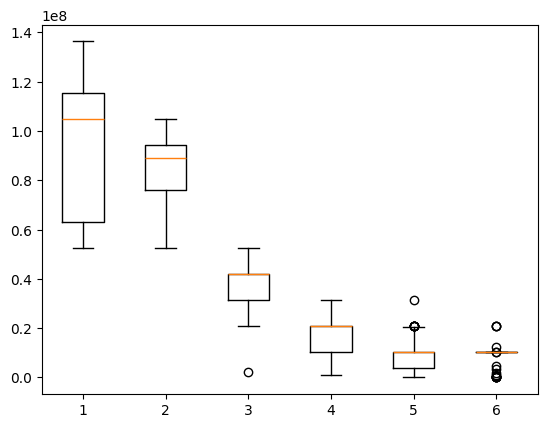

In [83]:
plt.boxplot(data[1:])

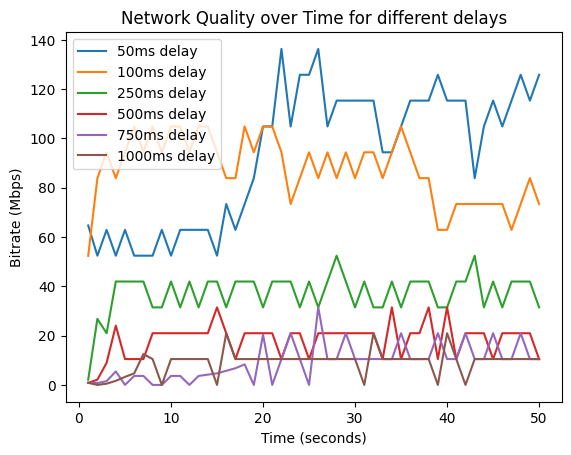

In [88]:
i = 0
for test in data:
    if i != 0:
        y = [val / (10**6) for val in test]
        plt.plot(x, y)
    i += 1
legend_labels = []
#legend_labels.append('No delay')
for delay in delays:
    legend_labels.append(f'{delay}ms delay')
plt.legend(legend_labels)
plt.xlabel('Time (seconds)')
plt.ylabel('Bitrate (Mbps)')
plt.title('Network Quality over Time for different delays')

plt.savefig('monitoring_without_delay.jpg')

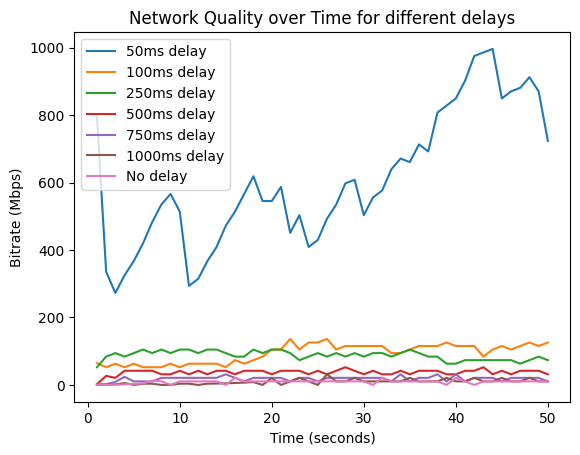

In [87]:
import matplotlib.pyplot as plt
x = [i for i in range(1, 51)]

for test in data:
    y = [val / (10**6) for val in test]
    plt.plot(x, y)
legend_labels = []
for delay in delays:
    legend_labels.append(f'{delay}ms delay')
legend_labels.append('No delay')
plt.legend(legend_labels)
plt.xlabel('Time (seconds)')
plt.ylabel('Bitrate (Mbps)')
plt.title('Network Quality over Time for different delays')

plt.savefig("netquality.jpg")

## Step 9: Delete the Slice

This concludes Lab 1. Please delete your slice when you are done with your experiment.

In [17]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager()
slice = fablib.get_slice(name="lab1")
slice.delete()